In [1]:
from fastai.vision.all import *
from self_supervised.layers import *
import sklearn

In [2]:
datapath = Path("../data/stanford-dogs-dataset/")

In [3]:
train_df = pd.read_csv(datapath/'train.csv')
test_df = pd.read_csv(datapath/'test.csv')
sample_df = pd.read_csv(datapath/'sample_train.csv')

In [4]:
train_df.shape, test_df.shape, sample_df.shape

((12000, 2), (8580, 2), (6000, 3))

In [5]:
train_df.head()

,filenames,labels
0,n02085620-Chihuahua/n02085620_5927.jpg,n02085620-Chihuahua
1,n02085620-Chihuahua/n02085620_4441.jpg,n02085620-Chihuahua
2,n02085620-Chihuahua/n02085620_1502.jpg,n02085620-Chihuahua
3,n02085620-Chihuahua/n02085620_1916.jpg,n02085620-Chihuahua
4,n02085620-Chihuahua/n02085620_13151.jpg,n02085620-Chihuahua


In [6]:
test_df.head()

,filenames,labels
0,n02085620-Chihuahua/n02085620_2650.jpg,n02085620-Chihuahua
1,n02085620-Chihuahua/n02085620_4919.jpg,n02085620-Chihuahua
2,n02085620-Chihuahua/n02085620_1765.jpg,n02085620-Chihuahua
3,n02085620-Chihuahua/n02085620_3006.jpg,n02085620-Chihuahua
4,n02085620-Chihuahua/n02085620_1492.jpg,n02085620-Chihuahua


In [7]:
sample_df.head()

,label,filename,split
0,n02085620-Chihuahua,n02085620-Chihuahua/n02085620_7292.jpg,valid
1,n02085620-Chihuahua,n02085620-Chihuahua/n02085620_500.jpg,valid
2,n02085620-Chihuahua,n02085620-Chihuahua/n02085620_1298.jpg,valid
3,n02085620-Chihuahua,n02085620-Chihuahua/n02085620_4290.jpg,valid
4,n02085620-Chihuahua,n02085620-Chihuahua/n02085620_4998.jpg,valid


### Dataset

In [8]:
def read_image(filename): return PILImage.create(datapath/'images/Images'/filename)
def read_image_size(filename): return PILImage.create(datapath/'images/Images'/filename).shape

In [9]:
# # sizes = parallel(read_image_size, filenames, progress=True)
# # Counter(sizes).most_common(10)
# [((375, 500), 1497),
#  ((333, 500), 602),
#  ((500, 375), 361),
#  ((500, 333), 196),
#  ((334, 500), 110),
#  ((332, 500), 78),
#  ((500, 500), 37),
#  ((500, 332), 37),
#  ((374, 500), 37),
#  ((357, 500), 34)]

In [10]:
FAST = True

In [11]:
if FAST:
    filenames = sample_df['filename'].values
    labels = sample_df['label'].values
    fn2label = dict(zip(filenames, labels))
else:
    filenames = train_df['filenames'].values
    labels = train_df['labels'].values
    fn2label = dict(zip(filenames, labels))

In [12]:
def read_label(filename): return fn2label[filename]

In [13]:
valid_filenames = sample_df.query("split == 'valid'")['filename'].values

In [14]:
size,bs = 384,32

tfms = [[read_image, ToTensor, RandomResizedCrop(size, min_scale=.75)], 
        [read_label, Categorize()]]

valid_splitter = lambda o: True if o in valid_filenames else False 
dsets = Datasets(filenames, tfms=tfms, splits=FuncSplitter(valid_splitter)(filenames))

batch_augs = aug_transforms()
# batch_augs = []

stats = imagenet_stats

batch_tfms = [IntToFloatTensor] + batch_augs + [Normalize.from_stats(*stats)]
dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)

In [15]:
len(dls.train_ds), len(dls.valid_ds)

(4800, 1200)

In [16]:
# dls.show_batch()

### Modifications on ViT

In [17]:
# from timm.models.helpers import build_model_with_cfg, overlay_external_default_cfg
from timm.models.layers import StdConv2dSame, DropPath, to_2tuple, trunc_normal_
from timm.models.resnet import resnet26d, resnet50d
from timm.models.resnetv2 import ResNetV2
from timm.models.registry import register_model

In [18]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [19]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        "Return attention output and weight before dropout"
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (self.attn_drop(attn) @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn

In [20]:
class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        out, attn = self.attn(self.norm1(x))
        x = x + self.drop_path(out)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x, attn

In [21]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, stride_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        stride_size = to_2tuple(stride_size)
        num_patches = ((img_size[0] - patch_size[0] + stride_size[0]) // stride_size[0])**2
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride_size)

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
#         assert H == self.img_size[0] and W == self.img_size[1], \
#             f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [22]:
class HybridEmbed(nn.Module):
    """ CNN Feature Map Embedding
    Extract feature map from CNN, flatten, project to embedding dim.
    """
    def __init__(self, backbone, img_size=224, feature_size=None, in_chans=3, embed_dim=768):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        self.img_size = img_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                # FIXME this is hacky, but most reliable way of determining the exact dim of the output feature
                # map for all networks, the feature metadata has reliable channel and stride info, but using
                # stride to calc feature dim requires info about padding of each stage that isn't captured.
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))
                if isinstance(o, (list, tuple)):
                    o = o[-1]  # last feature if backbone outputs list/tuple of features
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            if hasattr(self.backbone, 'feature_info'):
                feature_dim = self.backbone.feature_info.channels()[-1]
            else:
                feature_dim = self.backbone.num_features
        self.num_patches = feature_size[0] * feature_size[1]
        self.proj = nn.Conv2d(feature_dim, embed_dim, 1)

    def forward(self, x):
        x = self.backbone(x)
        if isinstance(x, (list, tuple)):
            x = x[-1]  # last feature if backbone outputs list/tuple of features
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [23]:
class VisionTransformer(nn.Module):
    """ Vision Transformer
    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`  -
        https://arxiv.org/abs/2010.11929
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=True, qk_scale=None, representation_size=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., hybrid_backbone=None, norm_layer=None):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            hybrid_backbone (nn.Module): CNN backbone to use in-place of PatchEmbed module
            norm_layer: (nn.Module): normalization layer
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        attn_wgts = []
        for blk in self.blocks:
            x,attn = blk(x)
            attn_wgt.append(attn)

        x = self.norm(x)[:, 0]
        x = self.pre_logits(x)
        return x, attn_wgts

    def forward(self, x):
        x,attn_wgts = self.forward_features(x)
        x = self.head(x)
        return x,attn_wgts

In [24]:
# class DistilledVisionTransformer(VisionTransformer):
#     """ Vision Transformer with distillation token.
#     Paper: `Training data-efficient image transformers & distillation through attention` -
#         https://arxiv.org/abs/2012.12877
#     This impl of distilled ViT is taken from https://github.com/facebookresearch/deit
#     """
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.dist_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
#         num_patches = self.patch_embed.num_patches
#         self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 2, self.embed_dim))
#         self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if self.num_classes > 0 else nn.Identity()

#         trunc_normal_(self.dist_token, std=.02)
#         trunc_normal_(self.pos_embed, std=.02)
#         self.head_dist.apply(self._init_weights)

#     def forward_features(self, x):
#         B = x.shape[0]
#         x = self.patch_embed(x)

#         cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
#         dist_token = self.dist_token.expand(B, -1, -1)
#         x = torch.cat((cls_tokens, dist_token, x), dim=1)

#         x = x + self.pos_embed
#         x = self.pos_drop(x)

#         for blk in self.blocks:
#             x = blk(x)

#         x = self.norm(x)
#         return x[:, 0], x[:, 1]

#     def forward(self, x):
#         x, x_dist = self.forward_features(x)
#         x = self.head(x)
#         x_dist = self.head_dist(x_dist)
#         if self.training:
#             return x, x_dist
#         else:
#             # during inference, return the average of both classifier predictions
#             return (x + x_dist) / 2

In [25]:
def resize_pos_embed(posemb, posemb_new):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    _logger.info('Resized position embedding: %s to %s', posemb.shape, posemb_new.shape)
    ntok_new = posemb_new.shape[1]
    if True:
        posemb_tok, posemb_grid = posemb[:, :1], posemb[0, 1:]
        ntok_new -= 1
    else:
        posemb_tok, posemb_grid = posemb[:, :0], posemb[0]
    gs_old = int(math.sqrt(len(posemb_grid)))
    gs_new = int(math.sqrt(ntok_new))
    _logger.info('Position embedding grid-size from %s to %s', gs_old, gs_new)
    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=(gs_new, gs_new), mode='bilinear')
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_new * gs_new, -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb

def checkpoint_filter_fn(state_dict, model):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    if 'model' in state_dict:
        # For deit models
        state_dict = state_dict['model']
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k and len(v.shape) < 4:
            # For old models that I trained prior to conv based patchification
            O, I, H, W = model.patch_embed.proj.weight.shape
            v = v.reshape(O, -1, H, W)
        elif k == 'pos_embed' and v.shape != model.pos_embed.shape:
            # To resize pos embedding when using model at different size from pretrained weights
            v = resize_pos_embed(v, model.pos_embed)
        out_dict[k] = v
    return out_dict


def _create_vision_transformer(variant, pretrained=False, distilled=False, **kwargs):
    default_cfg = deepcopy(default_cfgs[variant])
    overlay_external_default_cfg(default_cfg, kwargs)
    default_num_classes = default_cfg['num_classes']
    default_img_size = default_cfg['input_size'][-2:]

    num_classes = kwargs.pop('num_classes', default_num_classes)
    img_size = kwargs.pop('img_size', default_img_size)
    repr_size = kwargs.pop('representation_size', None)
    if repr_size is not None and num_classes != default_num_classes:
        # Remove representation layer if fine-tuning. This may not always be the desired action,
        # but I feel better than doing nothing by default for fine-tuning. Perhaps a better interface?
        _logger.warning("Removing representation layer for fine-tuning.")
        repr_size = None

    if kwargs.get('features_only', None):
        raise RuntimeError('features_only not implemented for Vision Transformer models.')

    model_cls = DistilledVisionTransformer if distilled else VisionTransformer
    model = build_model_with_cfg(
        model_cls, variant, pretrained,
        default_cfg=default_cfg,
        img_size=img_size,
        num_classes=num_classes,
        representation_size=repr_size,
        pretrained_filter_fn=checkpoint_filter_fn,
        **kwargs)

    return model

### Learner

In [26]:
from torch.utils.checkpoint import checkpoint_sequential, checkpoint
    
class CheckpointVisionTransformer(Module):
    def __init__(self, vit_model, checkpoint_nchunks=2):
        self.checkpoint_nchunks = checkpoint_nchunks
        self.vit_model = vit_model
    
    def forward_features(self, x):
        B = x.shape[0]
        x = self.vit_model.patch_embed(x)

        cls_tokens = self.vit_model.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.vit_model.pos_embed
        x = self.vit_model.pos_drop(x)

        # collect attn_wgts from all layers
        attn_wgts = []
        for i,blk in enumerate(self.vit_model.blocks):
            if i<self.checkpoint_nchunks: x,attn_wgt = checkpoint(blk, x)
            else:                         x,attn_wgt = blk(x)
            attn_wgts.append(attn_wgt)
            
            
        x = self.vit_model.norm(x)[:, 0]
        x = self.vit_model.pre_logits(x)
        return x,attn_wgts

    def forward(self, x):
        x,attn_wgts = self.forward_features(x)
        x           = self.vit_model.head(x)
        return x,attn_wgts

In [27]:
# timm vit _encoder
arch = "vit_base_patch16_384"
_encoder = create_encoder(arch, pretrained=True, n_in=3)

In [28]:
# custom vit encoder with timm weights
encoder = VisionTransformer(img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12)
encoder.head = Identity()
encoder.load_state_dict(_encoder.state_dict());

In [29]:
# grad checkpointing
encoder = CheckpointVisionTransformer(encoder, 12)

1) Change Stride Size

In [30]:
patch_size,stride_size = 16,16

new_patch_embed = PatchEmbed(size, patch_size, stride_size)
new_patch_embed.proj.weight.data = encoder.vit_model.patch_embed.proj.weight.data
new_patch_embed.proj.bias.data = encoder.vit_model.patch_embed.proj.bias.data
encoder.vit_model.patch_embed = new_patch_embed

2) Interpolate Position Embeddings to new Number of Patches

In [31]:
num_patches = ((size - patch_size + stride_size) // stride_size)**2 + 1

pos_embed_data = encoder.vit_model.pos_embed.data
new_pos_embed_data = F.interpolate(pos_embed_data[None, ...], 
                                   size=[num_patches, pos_embed_data.size(-1)], 
                                   mode='nearest')[0]
encoder.vit_model.pos_embed.data = new_pos_embed_data

3) Create Model

In [32]:
with torch.no_grad():
    out, attn_wgts = encoder(torch.randn(2,3,size,size))
    nf = out.size(1)
classifier = create_cls_module(nf, dls.c, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.)

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [33]:
class FGVCModel(Module):
    def __init__(self, encoder, classifier, return_attn_wgts=False):
        self.encoder = encoder
        self.classifier = classifier
        self.return_attn_wgts = return_attn_wgts
        
    def forward(self, x):
        cls_token,attn_wgts = self.encoder(x)
        if self.return_attn_wgts: return self.classifier(cls_token), attn_wgts, cls_token
        else:                     return self.classifier(cls_token)  

In [34]:
model = FGVCModel(encoder, classifier)

In [35]:
attn_wgts[0].shape

torch.Size([2, 12, 577, 577])

In [36]:
model.classifier

Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=768, out_features=120, bias=True)
)

In [37]:
# def model_splitter(m): return L(m[0], m[1]).map(params)
def model_splitter(m): return L(m.encoder, m.classifier).map(params)

In [38]:
cbs = []
# if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]
learn = Learner(dls, model, opt_func=ranger, cbs=cbs, metrics=[accuracy], splitter=model_splitter,
                loss_func=LabelSmoothingCrossEntropyFlat(0.1))
learn.to_fp16();

### Train for Warmup

In [39]:
# learn.lr_find()

In [40]:
# epochs = 2

# lr = 3e-3
# learn.freeze()
# learn.fit_one_cycle(epochs, lr_max=(lr), pct_start=0.5)

# lr /= 3 
# learn.unfreeze()
# learn.fit_one_cycle(int(epochs**2), lr_max=slice(lr/100, lr), pct_start=0.5)

# learn.save(f"{arch}_stride_{stride_size}_imsize_{size}")

### Multi Crop

In [41]:
from skimage import measure
import skimage

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage.filters import threshold_otsu, threshold_minimum, threshold_mean, threshold_yen, threshold_local
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, area_closing
from skimage.color import label2rgb

In [42]:
learn.load(f"{arch}_stride_{stride_size}_imsize_384");

In [43]:
size,bs = 448,16

tfms = [[read_image, ToTensor, RandomResizedCrop(size, min_scale=.75)], 
        [read_label, Categorize()]]

valid_splitter = lambda o: True if o in valid_filenames else False 
dsets = Datasets(filenames, tfms=tfms, splits=FuncSplitter(valid_splitter)(filenames))

batch_augs = aug_transforms()
# batch_augs = []

stats = imagenet_stats

batch_tfms = [IntToFloatTensor] + batch_augs + [Normalize.from_stats(*stats)]
dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)

In [44]:
learn.model.return_attn_wgts = True

In [45]:
learn.model.cuda();

In [46]:
for xb_448,yb in dls.valid:
    break

In [47]:
xb_384 = F.interpolate(xb_448, size=(384,384))

In [50]:
out, attn_wgts, cls_token = learn.model(xb_384)

In [51]:
xb_448 = xb_448.cpu()

In [52]:
xb_384.shape, xb_448.shape

(torch.Size([16, 3, 384, 384]), torch.Size([16, 3, 448, 448]))

In [139]:
def generate_batch_attention_maps(attn_wgts, targ_sz, mode='bilinear'):
    "Generate attention flow maps with shape (targ_sz,targ_sz) from L layer attetion weights of transformer model"
    # Stack for all layers - BS x L x K x gx x gy
    att_mat = torch.stack(attn_wgts, dim=1)
    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=2)
    # To account for residual connections, we add an identity matrix to the
    aug_att_mat = att_mat + torch.eye(att_mat.size(-1))[None,None,...].to(att_mat.device)
    # Re-normalize the weights.
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = aug_att_mat[:,0]
    for n in range(1, aug_att_mat.size(1)): joint_attentions = torch.bmm(aug_att_mat[:,n], joint_attentions)

    # BS x (num_patches+1) -> BS x gx x gy
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    joint_attentions = joint_attentions[:,0,1:].view(joint_attentions.size(0),grid_size,grid_size)
    joint_attentions /= torch.amax(joint_attentions, dim=(-2,-1), keepdim=True)

    # Bilinear interpolation to target size
    if mode == 'bilinear':
        joint_attentions = F.interpolate(joint_attentions[None,...], 
                                         (targ_sz,targ_sz), 
                                         mode=mode, align_corners=True)[0].detach().cpu().numpy()
    elif mode == 'nearest':
        joint_attentions = F.interpolate(joint_attentions[None,...], 
                                         (targ_sz,targ_sz), 
                                         mode=mode)[0].detach().cpu().numpy()
    elif mode is None:
        joint_attentions = joint_attentions.detach().cpu().numpy()
    
    return joint_attentions

In [140]:
attention_maps = generate_batch_attention_maps(attn_wgts, 448, mode='bilinear')

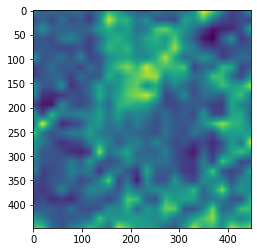

In [141]:
plt.imshow(attention_maps[0])

In [142]:
attention_maps = generate_batch_attention_maps(attn_wgts, 448, mode='nearest')

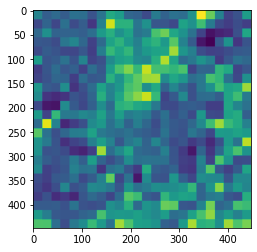

In [143]:
plt.imshow(attention_maps[0])

In [144]:
attention_maps = generate_batch_attention_maps(attn_wgts, 448, mode=None)

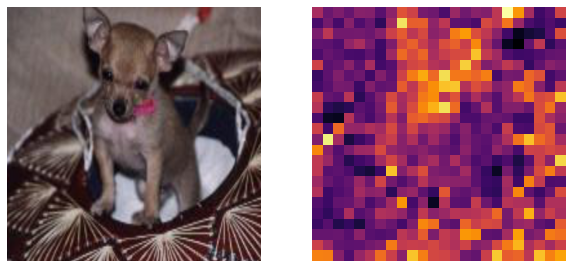

In [151]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
xb_448_decoded[0].show(ax=axes[0])
axes[1].imshow(attention_maps[0],cmap='inferno')
axes[1].set_axis_off();

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
xb_448_decoded[0].show(ax=axes[0])
axes[1].imshow(attention_maps[0],cmap='inferno')
axes[1].set_axis_off();

In [152]:
fig.savefig("grid_attention.png")

In [193]:
class SpatialTransfomerBlock(Module):
    def __init__(self):
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
#                             nn.Conv2d(1, 4, kernel_size=7),
                            nn.MaxPool2d(2, stride=7),
#                             nn.ReLU(True),
#                             nn.Conv2d(4, 8, kernel_size=7),
#                             nn.MaxPool2d(2, stride=2),
#                             nn.ReLU(True),
#                             nn.Conv2d(8, 8, kernel_size=7),
#                             nn.MaxPool2d(2, stride=2),
#                             nn.ReLU(True)
                        )

        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Linear(512, 2*4)
        )
        
        # ranges for each geometrc transform
        self.scale_range = SigmoidRange(0,1) # between 0-1 we always crop
        self.translate_range = SigmoidRange(-1,1) # stay inside image
        
    
    # Spatial transformer network forward function
    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(xs.size(0), -1)
        theta = self.fc_loc(xs)
        theta = theta.view(x.size(0),2,4)
        theta = torch.cat([self.scale_range(theta[:,:,:2]), self.translate_range(theta[:,:,2:])], dim=-1)

        # scalex,scaley,translatex,translatey -> affine matrix
        # [scalex,      0,   scalex*translatex]
        # [0     , scaley,   scaley*translatey]
        zeros = torch.zeros(theta.size(0),theta.size(1)).to(theta.device)
        theta = torch.stack([theta[:,:,0],
                             zeros,
                             theta[:,:,0]*theta[:,:,2],
                             zeros,
                             theta[:,:,1],
                             theta[:,:,1]*theta[:,:,3]], dim=-1).view(theta.size(0), theta.size(1), 2, 3)

        return theta # BS x 2 (num_crops) x 2 x 3
        
    def transform(self, x, theta, targ_sz=112):
        grid = F.affine_grid(theta, (x.size(0),x.size(1),targ_sz,targ_sz))
        out = F.grid_sample(x, grid)
        return out

In [198]:
st_model = SpatialTransfomerBlock()
theta_crops = st_model(attention_maps_tensor)

crops_1 = st_model.transform(xb_448_decoded.float(), theta_crops[:,0], targ_sz=144)
crops_2 = st_model.transform(xb_448_decoded.float(), theta_crops[:,1], targ_sz=96)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


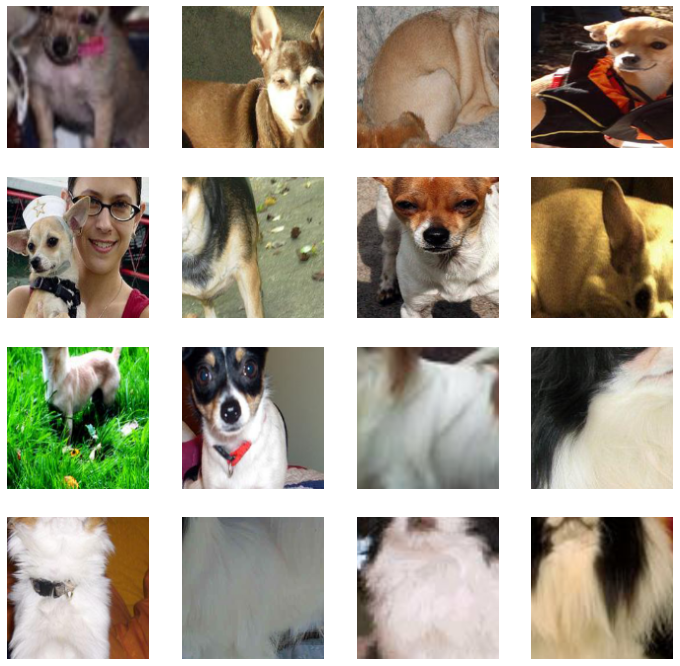

In [199]:
show_images(crops_1/255, nrows=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


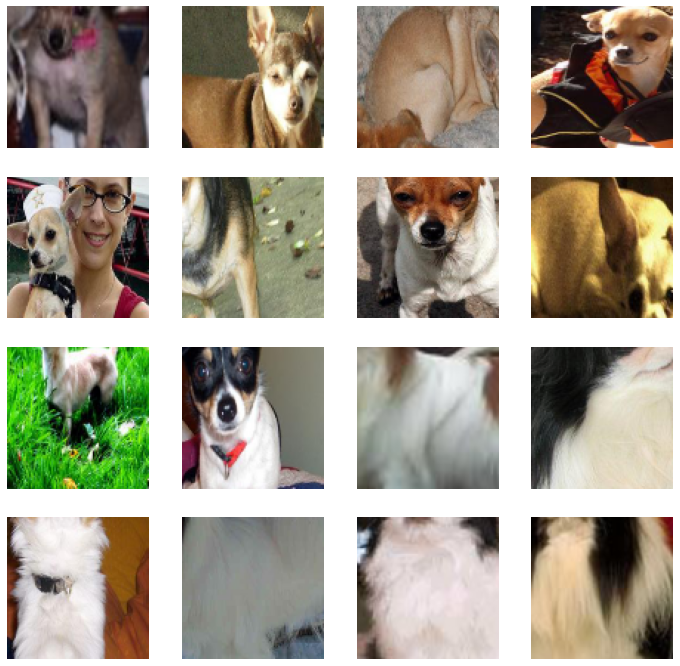

In [202]:
show_images(crops_2/255, nrows=4)

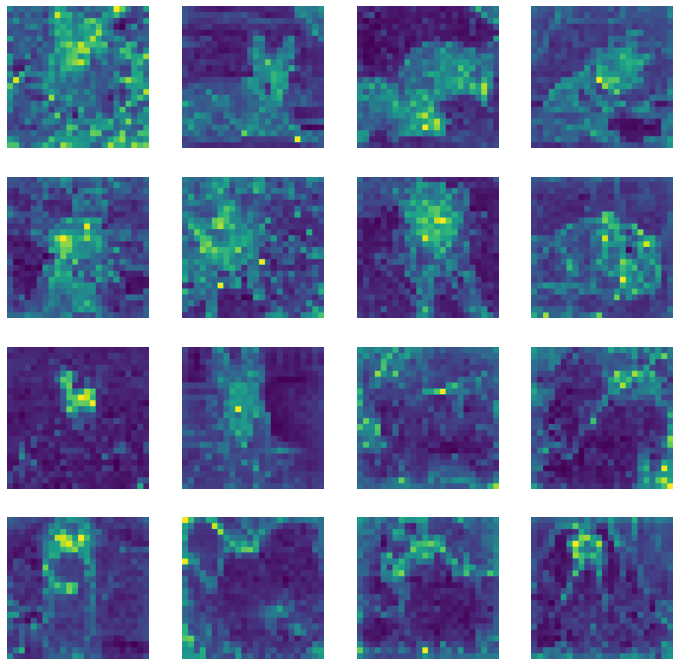

In [201]:
show_images(attention_maps_tensor, nrows=4)